In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from PIL import UnidentifiedImageError

In [ ]:
!unzip /content/drive/MyDrive/siriraj-eye-dataset/Image/all_images-001.zip

In [ ]:
import os

folder_path = '/content/all_images'
num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f'There are {num_files} files in the folder.')


There are 6168 files in the folder.


In [ ]:
csv_file_path = '/content/drive/MyDrive/siriraj-eye-dataset/all_labels_processed.csv'
df = pd.read_csv(csv_file_path)

df = df.drop(columns=['dr_label','camera','glaucoma_suspect', 'has_cup', 'has_disc', 'filename', 'dr_label_split', 'has_cup_split', 'has_disc_split'])

old_base_path = '../dataset/siriraj-eye-dataset-2023-jan/all_images'
new_base_path = '/content/all_images'
#df['path'] = df['path'].apply(lambda x: x.replace(old_base_path, new_base_path))
df['path'] = df['path'].apply(lambda x: x.replace(old_base_path, new_base_path).replace('\\', '/'))

#df.to_csv(/content/drive/MyDrive/siriraj-eye-dataset/dr_labels.csv, index=False)

In [ ]:
df.set_index('path', inplace=False)

,image_quality,image_quality_split
path,,
/content/all_images/0.jpg,NaN,NaN
/content/all_images/1.jpg,GOOD,train
/content/all_images/2.jpg,GOOD,train
/content/all_images/3.jpg,GOOD,train
/content/all_images/4.jpg,GOOD,train
...,...,...
/content/all_images/515L (C).jpg,GOOD,train
/content/all_images/596L (c).jpg,GOOD,train
/content/all_images/544L (C).jpg,ACCEPTABLE,train


In [ ]:
df = df.dropna(subset=['image_quality_split'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['image_quality_encoded'] = encoder.fit_transform(df['image_quality'])

In [ ]:
print(df)

                                  path image_quality image_quality_split  \
1            /content/all_images/1.jpg          GOOD               train   
2            /content/all_images/2.jpg          GOOD               train   
3            /content/all_images/3.jpg          GOOD               train   
4            /content/all_images/4.jpg          GOOD               train   
5            /content/all_images/5.jpg          GOOD               train   
...                                ...           ...                 ...   
6163  /content/all_images/515L (C).jpg          GOOD               train   
6164  /content/all_images/596L (c).jpg          GOOD               train   
6165  /content/all_images/544L (C).jpg    ACCEPTABLE               train   
6166  /content/all_images/538L (C).jpg    ACCEPTABLE                test   
6167  /content/all_images/282L (C).jpg          POOR               train   

      image_quality_encoded  
1                         1  
2                         1

In [ ]:
train_df = df[df['image_quality_split'] == 'train']
train_df, val_df = train_test_split(train_df, test_size=729, random_state=42, stratify=train_df['image_quality_encoded'])
test_df = df[df['image_quality_split'] == 'test']
train_df.drop(columns=['image_quality', 'image_quality_split'], inplace=True)
val_df.drop(columns=['image_quality', 'image_quality_split'], inplace=True)
test_df.drop(columns=['image_quality', 'image_quality_split'], inplace=True)

<ipython-input-21-7c11b0f471c0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['image_quality', 'image_quality_split'], inplace=True)


In [ ]:
 print(test_df)

                                  path  image_quality_encoded
25          /content/all_images/25.jpg                      1
32          /content/all_images/32.jpg                      0
33          /content/all_images/33.jpg                      1
35          /content/all_images/35.jpg                      1
48          /content/all_images/48.jpg                      1
...                                ...                    ...
6143  /content/all_images/541L (C).jpg                      1
6144  /content/all_images/443R (C).jpg                      1
6155  /content/all_images/394L (C).jpg                      0
6158  /content/all_images/213R (C).jpg                      1
6166  /content/all_images/538L (C).jpg                      0

[729 rows x 2 columns]


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (512, 512)
EPOCHS = 20

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
      img_path, label = self.dataframe.iloc[index]
      try:
        image = Image.open(img_path).convert('RGB')
      except UnidentifiedImageError:
        print(f"Skipping corrupted or unsupported image: {img_path}")
        image = Image.new('RGB', (512, 512), color='white')
      image = self.transform(image)
      return image, label


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = val_transform

In [ ]:
train_dataset = CustomDataset(train_df, transform=train_transform)
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = models.resnet50(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.model(x)
        return x


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 287MB/s]


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:

def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(torch.log(outputs), labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(data_loader), correct / total


In [ ]:

def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model(images)
            loss = criterion(torch.log(outputs), labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(data_loader), correct / total

In [ ]:
best_val_loss = 1.0
best_model_path = '/content/drive/MyDrive/siriraj-eye-dataset/quality_model.pth'
patience = 5
wait = 0

In [ ]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f'Epoch [{epoch+1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_loss < best_val_loss:
        print(f'New best model found! Previous best: {best_val_loss:.4f}, new best: {val_loss:.4f}. Saving model...')
        torch.save(model.state_dict(), best_model_path)
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1

    if wait > patience:
        print(f'Early stopping after {epoch+1} epochs')
        break

Epoch [1/20], Train Loss: 0.7935, Train Acc: 0.6362, Val Loss: 0.7726, Val Acc: 0.6475
New best model found! Previous best: 0.8472, new best: 0.7726. Saving model...
Epoch [2/20], Train Loss: 0.7389, Train Acc: 0.6670, Val Loss: 0.7297, Val Acc: 0.6818
New best model found! Previous best: 0.7726, new best: 0.7297. Saving model...
Epoch [3/20], Train Loss: 0.6949, Train Acc: 0.7005, Val Loss: 0.7212, Val Acc: 0.6872
New best model found! Previous best: 0.7297, new best: 0.7212. Saving model...
Epoch [4/20], Train Loss: 0.6717, Train Acc: 0.7041, Val Loss: 0.6994, Val Acc: 0.7037
New best model found! Previous best: 0.7212, new best: 0.6994. Saving model...
Epoch [5/20], Train Loss: 0.6801, Train Acc: 0.7170, Val Loss: 0.6793, Val Acc: 0.7010
New best model found! Previous best: 0.6994, new best: 0.6793. Saving model...
Epoch [6/20], Train Loss: 0.6516, Train Acc: 0.7170, Val Loss: 0.6683, Val Acc: 0.7106
New best model found! Previous best: 0.6793, new best: 0.6683. Saving model...
Epoc

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    print(f'Test Accuracy: {correct / total:.4f}')

    cm = confusion_matrix(all_labels, all_predictions)
    cm_df = pd.DataFrame(cm, index=['ACCEPTABLE', 'GOOD', 'POOR'], columns=['ACCEPTABLE', 'GOOD', 'POOR'])

    plt.figure(figsize=(10,7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap = 'Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Test Accuracy: 0.7229


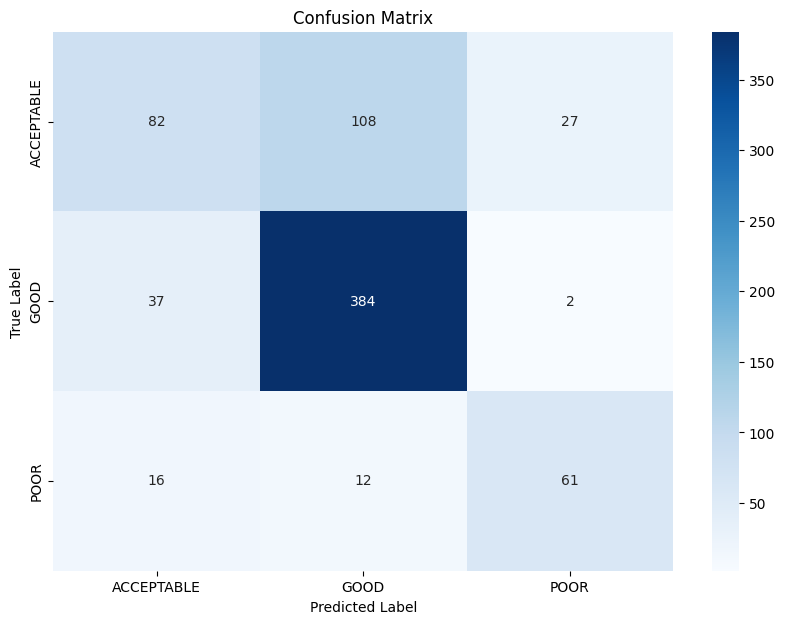

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/siriraj-eye-dataset/quality_model.pth'))
evaluate(model, test_loader, device)